# Guindaste Hidráulico Florestal


In [370]:
# Matemática simbólica, soluções analíticas:
import sympy as sp

# Operações com matrizes e vetores:
import numpy as np

# Gráficos e animações:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Integração numérica:
from scipy.integrate import solve_ivp, odeint

# Outros:
from IPython.display import display, HTML

# Funções Auxiliares

## Polinômio de Taylor de 1ª ordem

In [371]:
def taylor_linear(f, x, y, z, x0, y0, z0):
  alias = { x: x0, y: y0, z: z0 }
  dx = x - x0
  dy = y - y0
  dz = z - z0
  f_x = sp.diff(f, x)
  f_y = sp.diff(f, y)
  f_z = sp.diff(f, z)
  polynomial = f.subs(alias) + dx * f_x.subs(alias) + dy * f_y.subs(alias) + dz * f_z.subs(alias)
  return polynomial

## Campo de Velocidades 
- Corpo Rígido
- Composição de Velocidades

$\begin{bmatrix}u \\ v \\ 0 \end{bmatrix} = \begin{bmatrix} u_0 \\ v_0 \\ 0 \end{bmatrix} + \begin{bmatrix} 0 & 0 & \omega\end{bmatrix} \times \begin{bmatrix} r_x \\ r_y \\ 0 \end{bmatrix} \implies \begin{bmatrix}u \\ v \\ 0 \end{bmatrix} = \begin{bmatrix} u_0 \\ v_0 \\ 0 \end{bmatrix} + \begin{bmatrix} -\omega \cdot r_y \\ \omega \cdot r_x \\ 0  \end{bmatrix} \implies \begin{bmatrix}u \\ v \\ 0 \end{bmatrix} = \begin{bmatrix} u_0 -\omega \cdot r_y \\ v_0 + \omega \cdot r_x \\ 0  \end{bmatrix}$

In [372]:
def rigidbody_velocity(velocity_x, velocity_y, angular_velocity_z, radius_x, radius_y):
  return velocity_x - angular_velocity_z * radius_y, velocity_y + angular_velocity_z * radius_x

## Energia Cinética
- Barra Delgada Rígida
- Pólo na Extremidade da Barra

In [373]:
def kinetic_energy(mass, velocity_x, velocity_y, angular_velocity_z=0, moment_of_inertia=0, offset_x=0, offset_y=0):
  # Translação pura do pólo O:
  T_1 = 0.5 * mass * (velocity_x ** 2 + velocity_y ** 2)
  # Roto-translação de G em torno do pólo O:
  T_2 = mass * angular_velocity_z * (velocity_y * offset_x - velocity_x * offset_y)
  # Rotação pura em torno do pólo O:
  T_3 = 0.5 * moment_of_inertia * angular_velocity_z ** 2
  return T_1 + T_2 + T_3

In [374]:
def kinetic_energy_link(mass, length, theta, velocity_x, velocity_y, angular_velocity_z):
  # Braços de rotação (G - O)
  offset_x = length * sp.cos(theta) / 2
  offset_y = length * sp.sin(theta) / 2
  # Momento de inércia da barra delgada com extremidade em apoio duplo:
  moment_of_inertia = mass * length ** 2 / 3
  return kinetic_energy(mass, velocity_x, velocity_y, angular_velocity_z, moment_of_inertia, offset_x, offset_y)

## Energia Potencial Gravitacional

In [375]:
def gravitational_energy(mass, height):
  return mass * height * g

## Coordenadas polares

In [376]:
def polar_to_cartesian(r, theta):
  class_name = str(r.__class__)
  if "numpy" in class_name:
    x = r * np.cos(theta)
    y = r * np.sin(theta)
  elif "sympy" in class_name:
    x = r * sp.cos(theta)
    y = r * sp.sin(theta)
  return (x, y)

## Simplificação de Expressões

In [377]:
def simplify(expr):
  return sp.simplify(sp.expand(expr))

In [378]:
def coeffs(expr, term):
  return sp.simplify((expr - expr.coeff(term, n=0)) / term)

In [379]:
def remove_terms(expr, terms):
  res = expr * (1 - len(terms))
  for term in terms:
    res += expr.coeff(term, n=0)
  return res

## Impressão das expressões algébricas

In [380]:
# Imprime a expressão algébrica com notações simplificadas de d/dt.
def pprint(*args):
  for arg in args:
    display(arg.subs(alias))

# Constantes
$M :=$ massa [kg] do ponto material, sistema formado pelo gancho (manipulador) e pela carga

$m_i :=$ massa [kg] do i-ésimo elo do braço robótico

$M_c :=$ massa [kg] do cilindro (parte móvel) de cada atuador hidráulico

$L_i :=$ comprimento [mm] do i-ésimo elo do braço robótico

$d_j :=$ comprimento [mm] do braço de torque do j-ésimo atuador hidráulico 

$F_j :=$ força [kN] aplicada pelo j-ésimo atuador hidráulico

$A_{c} :=$ área [mm²] da seção circular dos cilindros (atuador hidráulico)

$g :=$ aceleração [mm/s²] da gravidade local


In [381]:
M, m_1, m_2, m_3, M_c = sp.symbols("M m_1 m_2 m_3 M_c")
L_1, L_2, L_3 = sp.symbols("L_1 L_2 L_3")
d_1, d_2 = sp.symbols("d_1 d_2")
F_1, F_2 = sp.symbols("F_1 F_2")
A_c = sp.symbols("A_c")
g = sp.symbols("g")
k, c = sp.symbols("k c")

# Entradas do sistema dinâmico
$p_j :=$ pressão [MPa] diferencial no j-ésimo atuador hidráulico

$\tau :=$ torque [kN.mm] aplicado na primeira junta ($J1$)

In [382]:
p_1, p_2, tau = sp.symbols("p_1 p_2 tau")

## Valores numéricos (protótipo)

In [1102]:
Params = {
    M: 1250,     # kg
    L_1: 2.150,  # m
    L_2: 3.750,  # m
    L_3: 2.135,  # m
    d_1: 0.500,  # m
    d_2: 0.500,  # m
    g: 9.807,    # m/s²
    M_c: 20.66,  # kg
    A_c: 1.964,  # 1e-3 m²
    k: 24308.3764659871,    # N*m/rad
    c: 1e6,    # N*m*s/rad
}
mu = Params[M] / (Params[L_1] + Params[L_2] + Params[L_3])
Params[m_1] = mu * Params[L_1]
Params[m_2] = mu * Params[L_2]
Params[m_3] = mu * Params[L_3]

# Estados internos do sistema dinâmico

In [1103]:
t = sp.symbols("t")
theta_1 = sp.Function("theta_1")(t)
theta_2 = sp.Function("theta_2")(t)
theta_3 = sp.Function("theta_3")(t)

omega_1 = sp.diff(theta_1, t)
omega_2 = sp.diff(theta_2, t)
omega_3 = sp.diff(theta_3, t)

alpha_1 = sp.diff(omega_1, t)
alpha_2 = sp.diff(omega_2, t)
alpha_3 = sp.diff(omega_3, t)

theta_dot_1 = sp.Function('\\dot{\\theta}_1')(t)
theta_dot_2 = sp.Function('\\dot{\\theta}_2')(t)
theta_dot_3 = sp.Function('\\dot{\\theta}_3')(t)
theta_ddot_1 = sp.Function('\\ddot{\\theta}_1')(t)
theta_ddot_2 = sp.Function('\\ddot{\\theta}_2')(t)
theta_ddot_3 = sp.Function('\\ddot{\\theta}_3')(t)

alias = {
    omega_1: theta_dot_1,
    omega_2: theta_dot_2,
    omega_3: theta_dot_3,
    alpha_1: theta_ddot_1,
    alpha_2: theta_ddot_2,
    alpha_3: theta_ddot_3,
}

# Posição dos pontos no sistema de coordenadas $(x, y)$

## Posição e velocidade absoluta do ponto $J_2$ em função do tempo

In [1104]:
# Descreve a posição do ponto J2 em relação ao ponto J1.
# Ou seja, o vetor determinado por J2 - J1.
def position_J2_J1(L_1, theta_1):
  return polar_to_cartesian(L_1, theta_1)

In [1105]:
x_J2, y_J2 = position_J2_J1(L_1, theta_1)
pprint(x_J2, y_J2)

L_1*cos(theta_1(t))

L_1*sin(theta_1(t))

In [1106]:
# Encontrando u e v pelo campo de velocidades do corpo rígido:
u_J2, v_J2 = rigidbody_velocity(0, 0, omega_1, x_J2, y_J2)
pprint(u_J2, v_J2)

-L_1*\dot{\theta}_1(t)*sin(theta_1(t))

L_1*\dot{\theta}_1(t)*cos(theta_1(t))

## Inclinação do Elo #2 em relação a direção horizontal ($\phi$)

In [1107]:
phi = theta_1 + theta_2 - sp.pi

## Inclinação do Elo #3 em relação a direção horizontal ($\psi$)

In [1108]:
psi = phi + theta_3 - sp.pi

## Posição e velocidade absoluta do ponto $J_3$ em função do tempo

In [1109]:
# Descreve a posição do ponto J3 em relação ao ponto J2.
# Ou seja, o vetor determinado por J3 - J2.
def position_J3_J2(L_2, phi):
  return polar_to_cartesian(L_2, phi)

In [1110]:
x_J3, y_J3 = position_J3_J2(L_2, phi)

In [1111]:
u_J3, v_J3 = rigidbody_velocity(u_J2, v_J2, omega_1 + omega_2, x_J3, y_J3)
pprint(u_J3, v_J3)

-L_1*\dot{\theta}_1(t)*sin(theta_1(t)) + L_2*(\dot{\theta}_1(t) + \dot{\theta}_2(t))*sin(theta_1(t) + theta_2(t))

L_1*\dot{\theta}_1(t)*cos(theta_1(t)) - L_2*(\dot{\theta}_1(t) + \dot{\theta}_2(t))*cos(theta_1(t) + theta_2(t))

## Posição do ponto P em relação ao ponto J3

In [1112]:
# Descreve a posição do ponto P em relação ao ponto J3.
# Ou seja, o vetor determinado por P - J3.
def position_P_J3(L_3, psi):
  return polar_to_cartesian(L_3, psi)

In [1113]:
x_P, y_P = position_P_J3(L_3, psi)
pprint(x_P, y_P)

L_3*cos(theta_1(t) + theta_2(t) + theta_3(t))

L_3*sin(theta_1(t) + theta_2(t) + theta_3(t))

In [1114]:
u_P, v_P = rigidbody_velocity(u_J3, v_J3, omega_1 + omega_2 + omega_3, x_P, y_P)
pprint(u_P, v_P)

-L_1*\dot{\theta}_1(t)*sin(theta_1(t)) + L_2*(\dot{\theta}_1(t) + \dot{\theta}_2(t))*sin(theta_1(t) + theta_2(t)) - L_3*(\dot{\theta}_1(t) + \dot{\theta}_2(t) + \dot{\theta}_3(t))*sin(theta_1(t) + theta_2(t) + theta_3(t))

L_1*\dot{\theta}_1(t)*cos(theta_1(t)) - L_2*(\dot{\theta}_1(t) + \dot{\theta}_2(t))*cos(theta_1(t) + theta_2(t)) + L_3*(\dot{\theta}_1(t) + \dot{\theta}_2(t) + \dot{\theta}_3(t))*cos(theta_1(t) + theta_2(t) + theta_3(t))

## Pontos de atuação das forças hidráulicas ($P_j$)

In [1115]:
P_1 = sp.Matrix(np.array(np.array((x_J2, y_J2)) + polar_to_cartesian(d_1, phi)))
P_2 = sp.Matrix(np.array(np.array((x_J3, y_J3)) + polar_to_cartesian(d_2, psi)))

In [1116]:
gamma_1, gamma_2 = sp.symbols("gamma_1 gamma_2")

### Hipótese simplificadora: a mudança de inclinação dos atuadores é desprezada

In [1117]:
gamma_alias = {
    gamma_1: 0,
    gamma_2: 0,
}

# Equações de Lagrange

## Energia Cinética do Sistema

### Energia Cinética do Elo #1

In [1118]:
T_1 = kinetic_energy_link(m_1, L_1, theta_1, 0, 0, omega_1)

### Energia Cinética do Elo #2

In [1119]:
T_2 = kinetic_energy_link(m_2, L_2, phi, u_J2, v_J2, omega_1 + omega_2)

### Energia Cinética do Elo #3

In [1120]:
T_3 = kinetic_energy_link(m_3, L_3, psi, u_J3, v_J3, omega_1 + omega_2 + omega_3)

### Energia Cinética do Ponto Material

In [1121]:
T_P = kinetic_energy(M, u_J3, v_J3, omega_1 + omega_2 + omega_3, M * L_2**2, x_P, y_P)

### Energia Cinética ($T$)

In [1122]:
T = T_1 + T_2 + T_3 + T_P
pprint(simplify(T))

0.5*L_1**2*M*\dot{\theta}_1(t)**2 + 0.166666666666667*L_1**2*m_1*\dot{\theta}_1(t)**2 + 0.5*L_1**2*m_2*\dot{\theta}_1(t)**2 + 0.5*L_1**2*m_3*\dot{\theta}_1(t)**2 - 1.0*L_1*L_2*M*\dot{\theta}_1(t)**2*cos(theta_2(t)) - 1.0*L_1*L_2*M*\dot{\theta}_1(t)*\dot{\theta}_2(t)*cos(theta_2(t)) - 0.5*L_1*L_2*m_2*\dot{\theta}_1(t)**2*cos(theta_2(t)) - 0.5*L_1*L_2*m_2*\dot{\theta}_1(t)*\dot{\theta}_2(t)*cos(theta_2(t)) - 1.0*L_1*L_2*m_3*\dot{\theta}_1(t)**2*cos(theta_2(t)) - 1.0*L_1*L_2*m_3*\dot{\theta}_1(t)*\dot{\theta}_2(t)*cos(theta_2(t)) + 1.0*L_1*L_3*M*\dot{\theta}_1(t)**2*cos(theta_2(t) + theta_3(t)) + 1.0*L_1*L_3*M*\dot{\theta}_1(t)*\dot{\theta}_2(t)*cos(theta_2(t) + theta_3(t)) + 1.0*L_1*L_3*M*\dot{\theta}_1(t)*\dot{\theta}_3(t)*cos(theta_2(t) + theta_3(t)) + 0.5*L_1*L_3*m_3*\dot{\theta}_1(t)**2*cos(theta_2(t) + theta_3(t)) + 0.5*L_1*L_3*m_3*\dot{\theta}_1(t)*\dot{\theta}_2(t)*cos(theta_2(t) + theta_3(t)) + 0.5*L_1*L_3*m_3*\dot{\theta}_1(t)*\dot{\theta}_3(t)*cos(theta_2(t) + theta_3(t)) + 1.0

## Energia Potencial do Sistema

In [1123]:
U_1 = gravitational_energy(m_1, y_J2 / 2)
U_2 = gravitational_energy(m_2, y_J2 + y_J3 / 2)
U_3 = gravitational_energy(m_3, y_J2 + y_J3 + y_P / 2)
U_P = gravitational_energy(M, y_J2 + y_J3 + y_P)
U_el = k * (theta_1**2 + theta_2**2 + theta_3**2) / 2
pprint(U_1, U_2, U_3, U_P, U_el)

L_1*g*m_1*sin(theta_1(t))/2

g*m_2*(L_1*sin(theta_1(t)) - L_2*sin(theta_1(t) + theta_2(t))/2)

g*m_3*(L_1*sin(theta_1(t)) - L_2*sin(theta_1(t) + theta_2(t)) + L_3*sin(theta_1(t) + theta_2(t) + theta_3(t))/2)

M*g*(L_1*sin(theta_1(t)) - L_2*sin(theta_1(t) + theta_2(t)) + L_3*sin(theta_1(t) + theta_2(t) + theta_3(t)))

k*(theta_1(t)**2 + theta_2(t)**2 + theta_3(t)**2)/2

In [1124]:
U = U_1 + U_2 + U_3 + U_P + U_el

## Potencial Dissipativo de Rayleigh do Sistema

In [1125]:
R = c * (omega_1**2 + omega_2**2 + omega_3**2) / 2

## Forças Hidráulicas ($F_j$)

In [1126]:
F_1 = A_c * p_1 - M_c * g * sp.sin(theta_1 - gamma_1)
F_2 = A_c * p_2 - M_c * g * sp.sin(phi - gamma_2)
pprint(F_1, F_2)

A_c*p_1 + M_c*g*sin(gamma_1 - theta_1(t))

A_c*p_2 + M_c*g*sin(-gamma_2 + theta_1(t) + theta_2(t))

## Forças Generalizadas: Princípio dos Trabalhos Virtuais

$F_1 :=$ força do primeiro atuador hidráulico, sobre o elo #2

$F_2 :=$ força do segundo atuador hidráulico, sobre o elo #3

$\delta r_1 :=$ deslocamento virtual associado à força $F_1$

$\delta r_2 :=$ deslocamento virtual associado à força $F_2$

$\delta q_1 :=$ deslocamento virtual associado à coordenada generalizada $\theta_1$

$\delta q_2 :=$ deslocamento virtual associado à coordenada generalizada $\theta_2$

$\delta q_3 :=$ deslocamento virtual associado à coordenada generalizada $\theta_3$

In [1127]:
dq1 = sp.Symbol("\delta q_1")
dq2 = sp.Symbol("\delta q_2")
dq3 = sp.Symbol("\delta q_3")

In [1128]:
F1_x = F_1 * sp.cos(theta_1 - gamma_1)
F1_y = F_1 * sp.sin(theta_1 - gamma_1)

In [1129]:
F2_x = F_2 * sp.cos(phi - gamma_2)
F2_y = F_2 * sp.sin(phi - gamma_2)

In [1130]:
def virtual_displacement(x):
  return dq1 * sp.diff(x, theta_1) + dq2 * sp.diff(x, theta_2) + dq3 * sp.diff(x, theta_3)

In [1131]:
dr1_x = virtual_displacement(P_1[0])
dr1_y = virtual_displacement(P_1[1])
dr2_x = virtual_displacement(P_2[0])
dr2_y = virtual_displacement(P_2[1])

In [1132]:
dW = sp.expand(F1_x * dr1_x + F1_y * dr1_y + F2_x * dr2_x + F2_y * dr2_y)

In [1133]:
T = T.subs(gamma_alias).subs(Params)
U = U.subs(gamma_alias).subs(Params)
dW = dW.subs(gamma_alias).subs(Params)

In [1134]:
Q_1 = coeffs(dW, dq1) + tau
Q_2 = coeffs(dW, dq2)
Q_3 = coeffs(dW, dq3)

In [1135]:
pprint(Q_1)
pprint(Q_2)
pprint(Q_3)

0.982*p_1*sin(theta_1(t) + theta_2(t))*cos(theta_1(t)) - 0.982*p_1*sin(theta_1(t))*cos(theta_1(t) + theta_2(t)) - 0.982*p_2*sin(theta_1(t) + theta_2(t))*cos(theta_1(t) + theta_2(t) + theta_3(t)) + 0.982*p_2*sin(theta_1(t) + theta_2(t) + theta_3(t))*cos(theta_1(t) + theta_2(t)) + tau - 101.30631*sin(theta_1(t) + theta_2(t))**2*cos(theta_1(t) + theta_2(t) + theta_3(t)) + 101.30631*sin(theta_1(t))**2*cos(theta_1(t) + theta_2(t)) - 25.3265775*cos(theta_1(t) - theta_2(t)) + 25.3265775*cos(3*theta_1(t) + theta_2(t)) + 25.3265775*cos(theta_1(t) + theta_2(t) - theta_3(t)) - 25.3265775*cos(3*theta_1(t) + 3*theta_2(t) + theta_3(t))

0.982*p_1*sin(theta_1(t) + theta_2(t))*cos(theta_1(t)) - 0.982*p_1*sin(theta_1(t))*cos(theta_1(t) + theta_2(t)) - 0.982*p_2*sin(theta_1(t) + theta_2(t))*cos(theta_1(t) + theta_2(t) + theta_3(t)) + 0.982*p_2*sin(theta_1(t) + theta_2(t) + theta_3(t))*cos(theta_1(t) + theta_2(t)) - 101.30631*sin(theta_1(t) + theta_2(t))**2*cos(theta_1(t) + theta_2(t) + theta_3(t)) + 101.30631*sin(theta_1(t))**2*cos(theta_1(t) + theta_2(t)) - 25.3265775*cos(theta_1(t) - theta_2(t)) + 25.3265775*cos(3*theta_1(t) + theta_2(t)) + 25.3265775*cos(theta_1(t) + theta_2(t) - theta_3(t)) - 25.3265775*cos(3*theta_1(t) + 3*theta_2(t) + theta_3(t))

-0.982*p_2*sin(theta_1(t) + theta_2(t))*cos(theta_1(t) + theta_2(t) + theta_3(t)) + 0.982*p_2*sin(theta_1(t) + theta_2(t) + theta_3(t))*cos(theta_1(t) + theta_2(t)) - 101.30631*sin(theta_1(t) + theta_2(t))**2*cos(theta_1(t) + theta_2(t) + theta_3(t)) + 25.3265775*cos(theta_1(t) + theta_2(t) - theta_3(t)) - 25.3265775*cos(3*theta_1(t) + 3*theta_2(t) + theta_3(t))

## Lagrange

$L = T - U$

$\frac{d}{dt}(\frac{\partial L}{\partial \dot{q_i}}) - \frac{\partial L}{\partial q_i} + \frac{\partial R}{\partial \dot{q_i}}=Q_i^{nc}$

In [1136]:
Lagrangian = T - U
Lagrangian = simplify(Lagrangian)

In [1137]:
ode1 = sp.diff(sp.diff(Lagrangian, omega_1), t) - sp.diff(Lagrangian, theta_1) + sp.diff(R, omega_1) - Q_1
ode2 = sp.diff(sp.diff(Lagrangian, omega_2), t) - sp.diff(Lagrangian, theta_2) + sp.diff(R, omega_2) - Q_2
ode3 = sp.diff(sp.diff(Lagrangian, omega_3), t) - sp.diff(Lagrangian, theta_3) + sp.diff(R, omega_3) - Q_3

In [1138]:
ode1 = simplify(ode1)
ode2 = simplify(ode2)
ode3 = simplify(ode3)

# Espaço de Estados

Para encontrar o espaço de estados a partir das equações diferenciais ordinárias, é necessário isolar as derivadas de segunda ordem $\ddot{\theta}_i \equiv \alpha_i$

$\begin{bmatrix}A\end{bmatrix} = \begin{bmatrix}a_{11} &  a_{12} & a_{13} \\ a_{21} & a_{22} & a_{23} \\ a_{31} & a_{32} & a_{33}  \end{bmatrix}$

$\begin{bmatrix}A\end{bmatrix} \begin{bmatrix}\ddot{\theta}_1 \\ \ddot{\theta}_2 \\ \ddot{\theta}_3 \end{bmatrix} = -\begin{bmatrix} b_1 \\ b_2 \\ b_3 \end{bmatrix}$

$\begin{bmatrix}\ddot{\theta}_1 \\ \ddot{\theta}_2 \\ \ddot{\theta}_3 \end{bmatrix} = - \begin{bmatrix}A\end{bmatrix}^{-1}  \begin{bmatrix} b_1 \\ b_2 \\ b_3 \end{bmatrix}$

**Fonte:** Notas de aula do Laboratório de Simulações Numéricas (PME3201)

In [1139]:
def state_space(eq1, eq2, eq3):
  # Matriz dos termos dependentes de alpha_i.
  A = sp.Matrix([
      [coeffs(eq1, alpha_1), coeffs(eq1, alpha_2), coeffs(eq1, alpha_3)],
      [coeffs(eq2, alpha_1), coeffs(eq2, alpha_2), coeffs(eq2, alpha_3)],
      [coeffs(eq3, alpha_1), coeffs(eq3, alpha_2), coeffs(eq3, alpha_3)],
  ])

  # Vetor dos termos independentes de alpha_i.
  B = sp.Matrix([
      remove_terms(eq1, [alpha_1, alpha_2, alpha_3]),
      remove_terms(eq2, [alpha_1, alpha_2, alpha_3]),
      remove_terms(eq3, [alpha_1, alpha_2, alpha_3]),
  ])

  # Matriz das derivadas de segunda ordem:
  Alpha = -A ** -1 * B

  return (sp.Matrix([ # espaço de estados
    omega_1,
    omega_2,
    omega_3,
    Alpha[0],
    Alpha[1],
    Alpha[2]
  ]),
  sp.Matrix([ # variáveis
    theta_1,
    theta_2,
    theta_3,
    omega_1,
    omega_2,
    omega_3
  ]))

In [1140]:
space, vars = state_space(ode1, ode2, ode3)

In [1141]:
pprint(vars)

Matrix([
[       theta_1(t)],
[       theta_2(t)],
[       theta_3(t)],
[\dot{\theta}_1(t)],
[\dot{\theta}_2(t)],
[\dot{\theta}_3(t)]])

### Conversão dos estados internos do sistema: $f_i(t) → x_i$
Conversão de função do tempo para variável.

In [1142]:
Theta_1, Omega_1, Alpha_1 = sp.symbols("Theta_1 Omega_1 Alpha_1")
Theta_2, Omega_2, Alpha_2 = sp.symbols("Theta_2 Omega_2 Alpha_2")
Theta_3, Omega_3, Alpha_3 = sp.symbols("Theta_3 Omega_3 Alpha_3")
FUNCTIONS_TO_SYMBOLS_DICT = {
    theta_1: Theta_1,
    omega_1: Omega_1,
    alpha_1: Alpha_1,
    theta_2: Theta_2,
    omega_2: Omega_2,
    alpha_2: Alpha_2,
    theta_3: Theta_3,
    omega_3: Omega_3,
    alpha_3: Alpha_3,
}

### Conversão do espaço de estados para o SCILAB

In [1143]:
i = 1
for x in space:
  scilab_code = "    dy(" + str(i) + ") = "
  scilab_code += sp.octave_code(x.subs(gamma_alias).subs(FUNCTIONS_TO_SYMBOLS_DICT))
  scilab_code += ";"
  print(scilab_code.replace("pi", "%pi"))
  i += 1

    dy(1) = Omega_1;
    dy(2) = Omega_2;
    dy(3) = Omega_3;
    dy(4) = -(-11337.4129783759*Omega_1.^2.*sin(Theta_3) + 6500.11677426882*Omega_1.^2.*sin(Theta_2 + Theta_3) - 22674.8259567517*Omega_1.*Omega_2.*sin(Theta_3) - 11337.4129783759*Omega_2.^2.*sin(Theta_3) + Omega_3.*c + 24308.3764659871*Theta_3 + 0.982*p_2.*sin(Theta_1 + Theta_2).*cos(Theta_1 + Theta_2 + Theta_3) - 0.982*p_2.*sin(Theta_1 + Theta_2 + Theta_3).*cos(Theta_1 + Theta_2) + 101.30631*sin(Theta_1 + Theta_2).^2.*cos(Theta_1 + Theta_2 + Theta_3) - 25.3265775*cos(Theta_1 + Theta_2 - Theta_3) + 29649.6024210485*cos(Theta_1 + Theta_2 + Theta_3) + 25.3265775*cos(3*Theta_1 + 3*Theta_2 + Theta_3)).*(-3.56925254093844e+25*cos(Theta_2).^5.*cos(Theta_3) - 1683728407.79335*cos(Theta_2).^5.*cos(Theta_2 + Theta_3) + 5.69283456550967e+25*cos(Theta_2).^5 - 5.35698679386871e+25*cos(Theta_2).^4.*cos(Theta_3).^2 + 4.60700864272709e+25*cos(Theta_2).^4.*cos(Theta_3).*cos(Theta_2 + Theta_3) + 2.12054033019379e+26*cos(Theta_2).^4.*cos(Th

# Impulsos das simulações

In [1144]:
input_alias = {
    p_1: 1,
    p_2: 1,
    tau: 1,
}

# Condições iniciais

In [1145]:
y0 = [0.5 * np.pi, 0.75 * np.pi, 0.5 * np.pi, 0, 0, 0]

# Solução das Equações Diferenciais

### Função para solução numérica da EDO, usando a biblioteca SCILAB

In [1146]:
def solve_ode(space, duration, size, boundary_conditions, method="RK45"):
  state_space = space.subs(FUNCTIONS_TO_SYMBOLS_DICT)

  def evaluate_state_space(t, y):
    vals = {
        "t": t,
        "Theta_1": y[0],
        "Theta_2": y[1],
        "Theta_3": y[2],
        "Omega_1": y[3],
        "Omega_2": y[4],
        "Omega_3": y[5],
    }

    # counter = 1
    # for eq in state_space:
    #   print("EDO " + str(counter))
    #   pprint(eq.subs(vals))
    #   pprint(sp.N(sp.re(eq.subs(vals))))
    #   counter+=1
    return [sp.N(sp.re(eq.subs(vals))) for eq in state_space]

  # return odeint(
  #     evaluate_state_space,
  #     boundary_conditions,
  #     np.linspace(0, duration, size))

  return solve_ivp(
      evaluate_state_space,
      [0, duration],
      boundary_conditions,
      dense_output=True,
      method=method)

### Solução do subsistema mecânico com Range-Kutta de 5ª ordem

In [1147]:
duration = 10
size = 100

In [1148]:
result_rk45 = solve_ode(space.subs(input_alias).subs(Params), duration, size, y0)

# Gráficos

### Função para plotagem da simulação, usando a biblioteca MATPLOTLIB

In [1149]:
def plot(result, duration, size):
  t = np.linspace(0, duration, size)
  max_length = Params[L_1] + Params[L_2] + Params[L_3]
  solution = result.sol(t)
  solution = np.mod(solution, 2*np.pi)

  plt.plot(t, solution.T)
  plt.xlabel('t')
  plt.legend([r'$\theta_1$', r'$\theta_2$', r'$\theta_3$', r'$\omega_1$', r'$\omega_2$', r'$\omega_3$'], shadow=True)
  plt.title('Guindaste Hidráulico Industrial')
  plt.axhline(linewidth=0.5, color='gray')
  plt.axvline(linewidth=0.5, color='gray')
  plt.show()

  pos_J2 = np.array(polar_to_cartesian(Params[L_1] * np.ones(size), solution[0]))
  phi = solution[0] + solution[1] - np.pi
  pos_J3 = pos_J2 + np.array(polar_to_cartesian(Params[L_2] * np.ones(size), phi))
  psi = phi + solution[2] - np.pi
  pos_P = pos_J3 + np.array(polar_to_cartesian(Params[L_3] * np.ones(size), psi))

  markers_on = [0, int(size / 2 - 1), size-1]
  plt.plot(pos_J2[0], pos_J2[1], '-D', markevery=markers_on, color="C0")
  plt.plot(pos_J3[0], pos_J3[1], '-D', markevery=markers_on, color="C1")
  plt.plot(pos_P[0], pos_P[1], '-D', markevery=markers_on, color="C2")
  plt.xlabel('x')
  plt.legend([r'$J2$', r'$J3$', r'$P$'], shadow=True)
  plt.title('Curva descrita pelos pontos J2, J3 e P')
  plt.axhline(linewidth=0.5, color='gray')
  plt.axvline(linewidth=0.5, color='gray')
  plt.axis('equal')
  plt.xlim([-max_length, max_length])
  plt.ylim([-max_length, max_length])
  for i in markers_on:
    plt.annotate(str(i+1), (pos_J2[0][i], pos_J2[1][i]), textcoords="offset points",xytext=(0, 10),ha="center")
    plt.annotate(str(i+1), (pos_J3[0][i], pos_J3[1][i]), textcoords="offset points",xytext=(0, 10),ha="center")
    plt.annotate(str(i+1), (pos_P[0][i], pos_P[1][i]), textcoords="offset points",xytext=(0, 10),ha="center")
  plt.show()

  markers_on = [0, int(size / 2 - 1), size-1]
  plt.plot(pos_J2[0], pos_J2[1], '-D', markevery=markers_on, color="C0")
  plt.xlabel('x')
  plt.title('Curva descrita pelo ponto J2 no espaço 2D')
  plt.axhline(linewidth=0.5, color='gray')
  plt.axvline(linewidth=0.5, color='gray')
  plt.axis('equal')
  plt.xlim([-max_length, max_length])
  plt.ylim([-max_length, max_length])
  for i in markers_on:
    plt.annotate(str(i+1), (pos_J2[0][i], pos_J2[1][i]), textcoords="offset points",xytext=(0, 10),ha="center")
  plt.show()

  plt.plot(pos_J3[0], pos_J3[1], '-D', markevery=markers_on, color="C1")
  plt.xlabel('x')
  plt.title('Curva descrita pelo ponto J3 no espaço 2D')
  plt.axhline(linewidth=0.5, color='gray')
  plt.axvline(linewidth=0.5, color='gray')
  plt.axis('equal')
  plt.xlim([-max_length, max_length])
  plt.ylim([-max_length, max_length])
  for i in markers_on:
    plt.annotate(str(i+1), (pos_J3[0][i], pos_J3[1][i]), textcoords="offset points",xytext=(0, 10),ha="center")
  plt.show()

  plt.plot(pos_P[0], pos_P[1], '-D', markevery=markers_on, color="C2")
  plt.xlabel('x')
  plt.title('Curva descrita pelo ponto P no espaço 2D')
  plt.axhline(linewidth=0.5, color='gray')
  plt.axvline(linewidth=0.5, color='gray')
  plt.axis('equal')
  plt.xlim([-max_length, max_length])
  plt.ylim([-max_length, max_length])
  for i in markers_on:
    plt.annotate(str(i+1), (pos_P[0][i], pos_P[1][i]), textcoords="offset points",xytext=(0, 10),ha="center")
  plt.show()

  # Animação:
  fig, ax = plt.subplots()
  line_link_1, = ax.plot([], [], color="C0", linewidth=2)
  line_link_2, = ax.plot([], [], color="C1", linewidth=2)
  line_link_3, = ax.plot([], [], color="C2", linewidth=2)
  line_actuator_1, = ax.plot([], [], color="gray", linewidth=1)
  line_actuator_2, = ax.plot([], [], color="gray", linewidth=1)

  line_resolution = 10
  frame_interval_ms = 1000 * duration / size

  pos_J2_T = pos_J2.T
  pos_J3_T = pos_J3.T
  pos_P_T = pos_P.T
  pos_P1_T = np.array(pos_J2 + polar_to_cartesian(np.ones(size) * Params[d_1], phi)).T
  pos_P2_T = np.array(pos_J3 + polar_to_cartesian(np.ones(size) * Params[d_2], psi)).T

  def init():
      ax.set_xlim([-max_length, max_length])
      ax.set_ylim([-max_length, max_length])
      return (line_link_1, line_link_2)

  def update(frame):
      line_link_1.set_data(np.linspace(
          [0, 0],
          pos_J2_T[frame],
          line_resolution).T)
      line_link_2.set_data(np.linspace(
          pos_J2_T[frame],
          pos_J3_T[frame],
          line_resolution).T)
      line_link_3.set_data(np.linspace(
          pos_J3_T[frame],
          pos_P_T[frame],
          line_resolution).T)
      line_actuator_1.set_data(np.linspace(
          [0, 0],
          pos_P1_T[frame],
          line_resolution).T)
      line_actuator_2.set_data(np.linspace(
          pos_J2_T[frame],
          pos_P2_T[frame],
          line_resolution).T)
      return (line_link_1, line_link_2)

  anim = FuncAnimation(fig, update, frames=size, init_func=init,
                      interval=frame_interval_ms, blit=True)
  display(HTML(anim.to_html5_video()))

# Simulação do sistema não-linear

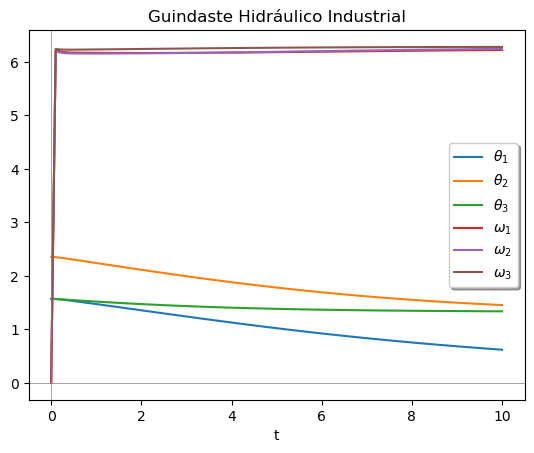

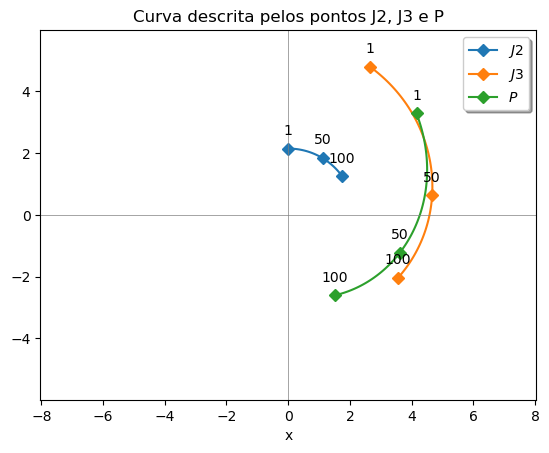

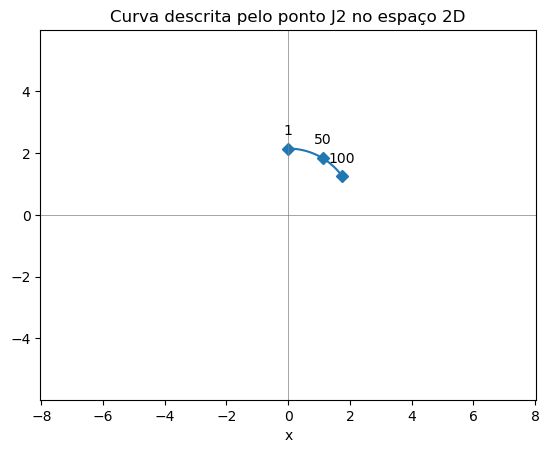

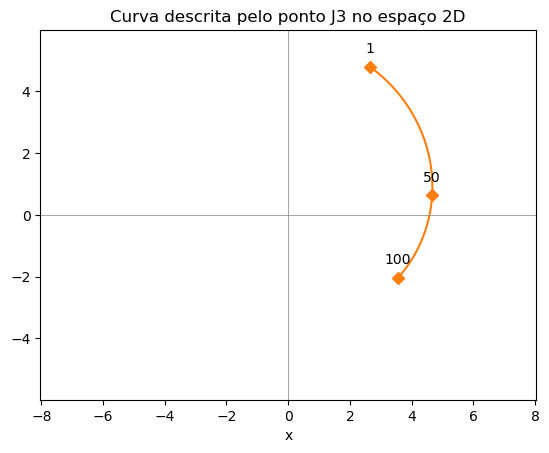

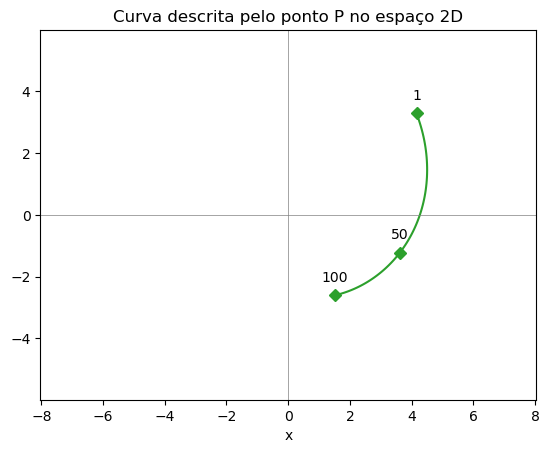

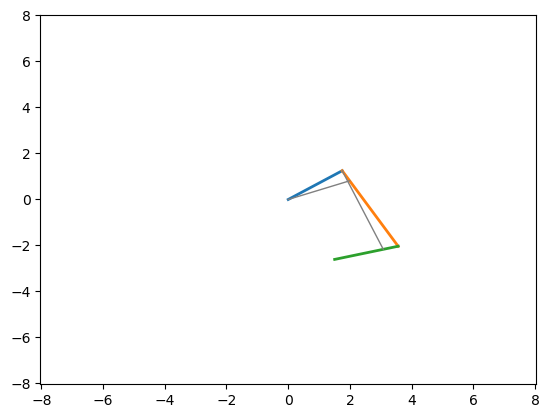

In [1150]:
plot(result_rk45, duration, size)

# Linearização do Modelo Matemático

## Aproximação por séries de Taylor

In [1151]:
linear_space = taylor_linear(space, theta_1, theta_2, theta_3, y0[0], y0[1], y0[2]).doit()
linear_space[3] = omega_1
linear_space[4] = omega_2
linear_space[5] = omega_3

In [1152]:
substitute = Params.copy()
substitute[theta_1] = 0.5 * sp.pi
substitute[theta_2] = 0.75 * sp.pi 
substitute[theta_3] = 0.5 * sp.pi

In [1153]:
# É necessário pois senão o sistema "linear" irá apresentar termos do vetor de entradas na matriz A.
remove_inputs_alias = {
    p_1: 0,
    p_2: 0,
    tau: 0,
}

In [1154]:
A = list()
for f in space:
  A.append(list())
  for x in vars:
    A[-1].append(sp.N(sp.diff(f, x).subs(remove_inputs_alias).subs(substitute).doit()))
print(A)

[[0, 0, 0, 1.00000000000000, 0, 0], [0, 0, 0, 0, 1.00000000000000, 0], [0, 0, 0, 0, 0, 1.00000000000000], [-0.272532484734331, 20.7794775641437, -2.92560309607353, -208.798301585251, 298.079468204669, -142.353461848981], [2.33949717294628, -31.6368341557284, 5.83928276377584, 298.079468204669, -465.563303867486, 243.249593421963], [-3.29961261263182, 13.2206364787286, -4.36117144273847, -142.353461848981, 243.249593421963, -192.380720060247]]


In [1155]:
B = list()
for f in space:
  B.append(list())
  for u in [p_1, p_2, tau]:
    B[-1].append(sp.N(sp.diff(f, u).subs(substitute).doit()))
print(B)

[[0, 0, 0], [0, 0, 0], [0, 0, 0], [-6.19949546185575e-5, 5.21169939154305e-5, 0.000208798301585251], [0.000116297234729458, -7.44019741194813e-5, -0.000298079468204669], [-7.00601407317925e-5, 8.98378658944935e-5, 0.000142353461848981]]


In [1156]:
def list_to_scilab_matrix(matrix: list[list[float]], varname: str) -> str:
  scilab_code = varname + " = [" 
  for row in matrix:
    for value in row:
      scilab_code += " " + str(value)
    scilab_code += ";"
  scilab_code = scilab_code[:-1]
  scilab_code += "]"
  return scilab_code

In [1157]:
print(list_to_scilab_matrix(A, 'A'))
print(list_to_scilab_matrix(B, 'B'))

A = [ 0 0 0 1.00000000000000 0 0; 0 0 0 0 1.00000000000000 0; 0 0 0 0 0 1.00000000000000; -0.272532484734331 20.7794775641437 -2.92560309607353 -208.798301585251 298.079468204669 -142.353461848981; 2.33949717294628 -31.6368341557284 5.83928276377584 298.079468204669 -465.563303867486 243.249593421963; -3.29961261263182 13.2206364787286 -4.36117144273847 -142.353461848981 243.249593421963 -192.380720060247]
B = [ 0 0 0; 0 0 0; 0 0 0; -6.19949546185575e-5 5.21169939154305e-5 0.000208798301585251; 0.000116297234729458 -7.44019741194813e-5 -0.000298079468204669; -7.00601407317925e-5 8.98378658944935e-5 0.000142353461848981]


# Simulação do sistema linearizado

In [1158]:
linear = solve_ode(linear_space.subs(input_alias).subs(Params), duration, size, y0)

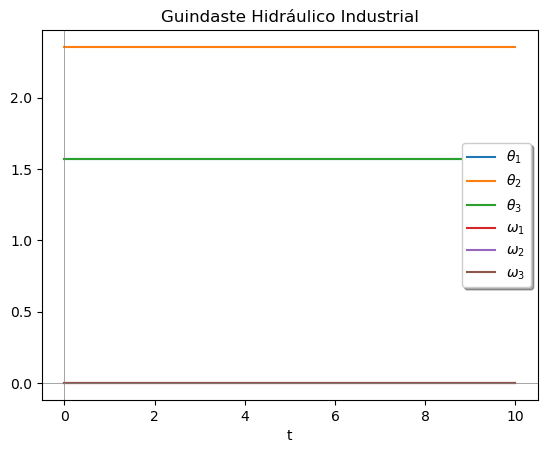

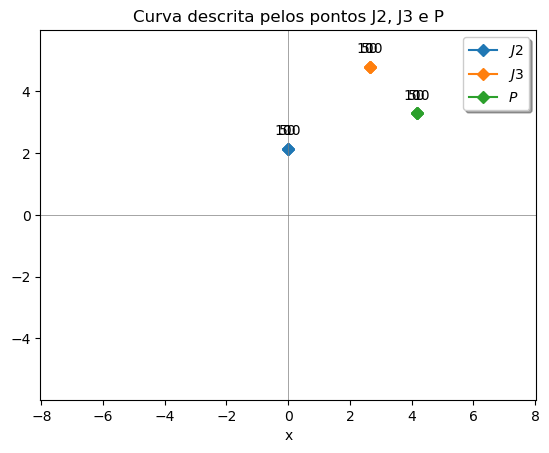

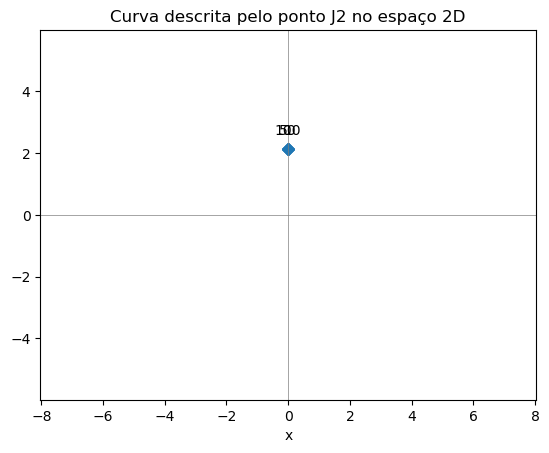

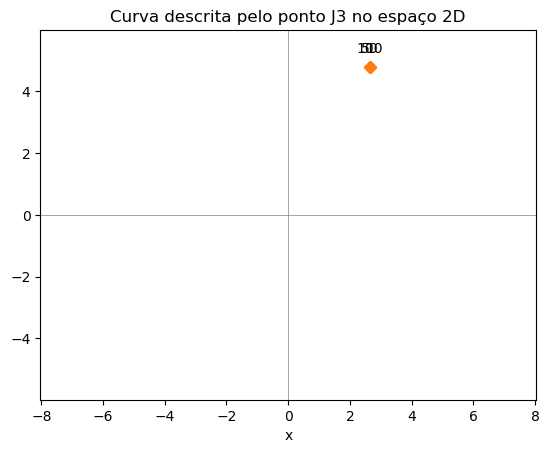

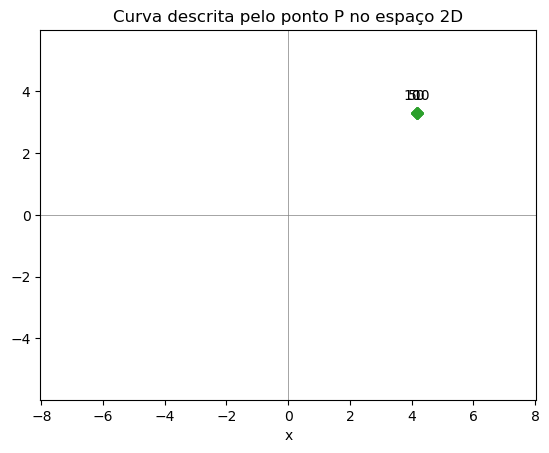

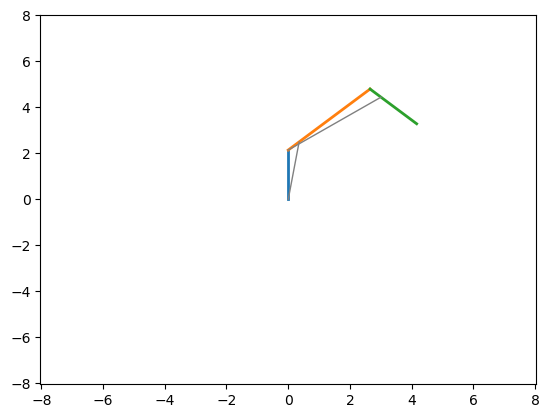

In [1159]:
plot(linear, duration, size)

# Equilíbrio Estático: 2ª Lei de Newton

In [1160]:
# Força de reação na vertical da Junta J1
V = sp.symbols("V")

In [1161]:
# Força resultante na vertical (y)
F_y = V \
    - m_1 * g * sp.sin(theta_1) \
    - m_2 * g * sp.sin(phi) \
    - m_3 * g * sp.sin(psi) \
    - M * g * sp.sin(psi) \
    + F1_y \
    + F2_y

In [1162]:
# Momento resultante no sistema em relação ao pólo J1
M_J1 = tau \
    - m_1 * g * sp.sin(theta_1) * (x_J2 / 2) \
    - m_2 * g * sp.sin(phi) * (x_J2 + x_J3 / 2) \
    - m_3 * g * sp.sin(psi) * (x_J2 + x_J3 + x_P / 2) \
    - M * g * sp.sin(psi) * (x_J2 + x_J3 + x_P) \
    - k * (theta_1 + phi + psi) \
    + F1_y * P_1[0] \
    + F2_y * P_2[0]

In [1163]:
substitute

{M: 1250,
 L_1: 2.15,
 L_2: 3.75,
 L_3: 2.135,
 d_1: 0.5,
 d_2: 0.5,
 g: 9.807,
 M_c: 20.66,
 A_c: 1.964,
 k: 24308.3764659871,
 c: 1000000,
 m_1: 334.474175482265,
 m_2: 583.3851897946483,
 m_3: 332.14063472308646,
 theta_1(t): 0.5*pi,
 theta_2(t): 0.75*pi,
 theta_3(t): 0.5*pi}

In [1164]:
substitute[k] = None
F_y = F_y.subs(substitute).subs(remove_inputs_alias).subs(gamma_alias)
M_J1 = M_J1.subs(substitute).subs(remove_inputs_alias).subs(gamma_alias)

In [1165]:
F_y

V - 2860.62927815806*sqrt(2) - 3584.10716895457 - 15516.0532047293*sin(1.75*pi)

In [1166]:
M_J1

-0.5*pi*k - 5363.67989654636 - 240.60248625*sqrt(2) - 50.653155*cos(1.75*pi) - 3257.30320472931*(1.0675*cos(1.75*pi) + 1.875*sqrt(2))*sin(1.75*pi) - 12258.75*(2.135*cos(1.75*pi) + 1.875*sqrt(2))*sin(1.75*pi)

In [1167]:
sp.solve([F_y, M_J1], [k, V])

{V: -3341.85854726810, k: 24304.6408582835}